In [1]:
import numpy as np
import pickle
from scipy.spatial.distance import cosine
import scipy
from numpy import linalg as LA
import random
from tqdm import tqdm
import sys
import argparse
from scipy.stats import pearsonr,spearmanr,percentileofscore
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import operator
import sys
import pdb
from os.path import join
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import spacy

/nlp/scr/cpenelto/miniconda3/envs/candice-base/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
2022-05-23 09:57:22.693823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 09:57:22.693876: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
files = ['COFEA','COCA']
fnames = [join('data','preprocessed',x) for x in files]

In [3]:
# Load the w2vec model
def load_embeddings_from_np(filename):
    # load word embedding file and vocab file from file_prefix
    print('loading %s'%filename)
    with open(filename + '.vocab', 'r') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')
    
    # filter out terms
    filtered_vocab = [word for word in vocab if special_filter.match(word) is None]
    filtered_w2i = {}
    filtered_wv = []
    for i,word in enumerate(filtered_vocab):
        filtered_wv.append(wv[w2i[word]])
        filtered_w2i[word] = i
        
    vocab = filtered_vocab
    wv = filtered_wv
    w2i = filtered_w2i
    
    return vocab, wv, w2i

def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

def load_and_normalize(lang, filename, vocab, wv, w2i):
    # load word embeddings, vocab file and update the global maps (vocab, wv, w2i)

    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)

    # normalize the word embeddings
    wv_muse = normalize(wv_muse)

    # update the global maps
    vocab[lang] = vocab_muse
    wv[lang] = wv_muse
    w2i[lang] = w2i_muse
    print('loaded and normalized %s embeddings'%filename)
    
def align(w2i, wv, vocab, space1, space2, aligned):
    # align the word embeddings from two spaces using orthogonal procrustes (OP)

    # identify the common words in both spaces
    train_words = list(set(vocab[space1]).intersection(set(vocab[space2])))
    
    # perform OP
    num = len(train_words)
    mat_bef = np.zeros((num, 300))
    mat_aft = np.zeros((num, 300))
    for i, w in enumerate(train_words):
        mat_bef[i, :] = wv[space1][w2i[space1][w]]
        mat_aft[i, :] = wv[space2][w2i[space2][w]]
    Q_bef, s_bef = scipy.linalg.orthogonal_procrustes(mat_bef, mat_aft)
    
    # update the global maps
    create_aligned(w2i, wv, vocab, Q_bef, space1, aligned)

    # normalize the aligned embeddings
    wv[aligned] = normalize(wv[aligned])
    
def create_aligned(w2i, wv, vocab, Q_bef, space1, aligned):
    # update the global maps with the aligned vectors, vocab and word to sequence id mapping
    wv[aligned] = np.zeros(wv[space1].shape)
    for i, vec in enumerate(wv[space1]):
        wv[aligned][i, :] = np.dot(vec, Q_bef)
    vocab[aligned] = vocab[space1]
    w2i[aligned] = w2i[space1]

    
def load_all_embeddings(name_a,name_b,embed_a,embed_b):
    # loads embedding from both spaces and performs alignment
    vocab = {}
    wv = {}
    w2i = {}
    load_and_normalize(name_a, embed_a, vocab, wv, w2i)
    load_and_normalize(name_b, embed_b, vocab, wv, w2i)
    align(w2i, wv, vocab, name_a, name_b, name_a+'_a')
    return vocab, wv, w2i



In [4]:
def extract_freqs(filename, vocab):
    # extract word raw frequencies and normalized frequencies

    # raw counts
    print('extracting freqs %s'%filename)
    count = defaultdict(int)
    with open(filename, 'r') as f:
        for l in f:
            for w in l.strip().split():
                count[w] += 1

    # consider only words in the vocabulary
    count_vocab = defaultdict(int)
    for w in vocab:
        if w in count:
            count_vocab[w] = count[w]

    # normalized frequencies
    tot = sum([count_vocab[item] for item in count_vocab])
    freq_norm = defaultdict(int)
    for w in count_vocab:
        freq_norm[w] = count_vocab[w] / float(tot)

    # top-frequent
    top_freq = defaultdict(int)
    sorted_words = [x[0] for x in sorted(count_vocab.items(), key=operator.itemgetter(1))]
    cutoff = len(sorted_words) / float(20)
    top_freq_words = sorted_words[int(4 * cutoff):-200]  # -int(cutoff)]
    for w in top_freq_words:
        top_freq[w] = count[w]

    print('done')
    return freq_norm, count_vocab, top_freq

In [5]:
def topK(w, space, k=10, count = None, min_freq = 0):
    # identify the top k neighbors of a word in a space

    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]

    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)

    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    if count:
        # consider only the neighbors whose raw frequency is greater than min_freq
        best = []
        for i in sort_sim:
            if i != idx and count[vocab[space][i]] > min_freq:
                best.append(i)
                if len(best) == k:
                    break
    else:
        best = sort_sim[:(k + 1)]

    return [vocab[space][i] for i in best if i != idx]

def NN_scores(space1, sapce2, freq1, freq2, count1, count2,K,MIN_COUNT,s_words,t_words):
    # rank all the words based on our method  
    # compute nearest neighbors overlap for all the common words
    nn_scores = []
    # ignore punctuation and other problem terms in the spaces
    pbar = tqdm(total=len(vocab[space1]))
    for i, w in enumerate(vocab[space1]):
        if w not in s_words and w in freq1  and w in freq2:
            if count1[w] > MIN_COUNT and count2[w] > MIN_COUNT or w in t_words:
                neighbors_bef = set(topK(w, space1, K, count1, 100))
                neighbors_aft = set(topK(w, sapce2, K, count2, 100))
                nn_scores.append((len(neighbors_bef.intersection(neighbors_aft)), w))
        if i%10 == 0:
            pbar.update(10)
    pbar.close()
    print('len of ranking', len(nn_scores))

    # rank these words
    nn_scores_sorted = sorted(nn_scores)
    return nn_scores_sorted


def cosdist_scores(space1, space2, freq1, freq2, count1, count2,MIN_COUNT,s_words,t_words):
    # compute cosine similarity for common words and sort these words from low similarity to high

    # compute cosine similarity for common words
    all_scores = []
    pbar = tqdm(total=len(vocab[space1]))
    for i, w in enumerate(vocab[space1]):
        if w not in s_words and w in freq1 and w in freq2:
            if count1[w] > MIN_COUNT and count2[w] > MIN_COUNT or w in t_words:
                all_scores.append((np.inner(wv[space1][w2i[space1][w], :], wv[space2][w2i[space2][w], :]), w))
        if i%10 == 0:
            pbar.update(10)
    pbar.close()
    print('len of ranking', len(all_scores))

    # rank these words
    all_scores_sorted = sorted(all_scores)
    return all_scores_sorted


In [6]:
def diff_nn(w, count1, count2, MIN_COUNT,K):
    # identify top 10 neighbors that are specific in a space

    # identify the neighbors 
    nn1 = topK(w, val1, K, count1, MIN_COUNT)
    nn2 = topK(w, val2, K, count2, MIN_COUNT)

    # identify the top 10 neighbors that specific to a space
    top_diff1 = []
    top_diff2 = []
    for w in nn1:
        if w not in nn2:
            top_diff1.append(w)
            if len(top_diff1) == 10:
                break
    for w in nn2:
        if w not in nn1:
            top_diff2.append(w)
            if len(top_diff2) == 10:
                break
    return top_diff1, top_diff2

In [8]:
MIN_COUNT = 200 # default 200
K = 1000 #default 1000
freq_thr = .00001 # default .00001
s_words = set(stopwords.words('french'))
top_k = 10 #default top k different value
special_filter = re.compile('.*(•|∣|\W|\d).*|^\w\.?$')
nlp = spacy.load("en_core_web_sm")
#special_filter = re.compile('a^')# match with nothing for now

# get all terms in the constitution
with open(join('data','constitution_words.txt'), 'r',encoding = 'utf-8') as f:
    target_words = f.read().splitlines()
    
target_words = [x.replace(' ','') for x in target_words]
ddo_terms = ['domesticviolence','publicuse','commerce','naturalborn']

# target_words = []
# name_a,name_b,embed_a,embed_b
val1 = files[0] # time_period[0]
val1fname = fnames[0]
val2 = files[1]# time_period[1]
val2fname = fnames[1]

vocab, wv, w2i = load_all_embeddings(val1,val2,
                                    val1fname,val2fname)

# extract frequencies
freq_norm_val1, count_vocab_val1, top_freq_val1 = extract_freqs(
    val1fname+'.txt', vocab[val1])

freq_norm_val2, count_vocab_val2, top_freq_val2 = extract_freqs(
    val2fname+'.txt', vocab[val2])


loading data/preprocessed/COFEA
loaded and normalized data/preprocessed/COFEA embeddings
loading data/preprocessed/COCA
loaded and normalized data/preprocessed/COCA embeddings
extracting freqs data/preprocessed/COFEA.txt
done
extracting freqs data/preprocessed/COCA.txt
done


In [10]:
# detect words using nn
print('detecting words using NN ...')
nn = NN_scores(val1 + '_a', val2, top_freq_val1, top_freq_val2, count_vocab_val1,
                        count_vocab_val2,K,MIN_COUNT,s_words,target_words)
print('done.')    

detecting words using NN ...


72480it [24:35, 49.14it/s]                                                      

len of ranking 14265
done.


In [11]:
def print_stats(score,key_word):
    #print number of mutual nearest neighbors
    top_diff1, top_diff2 = diff_nn(key_word, count_vocab_val1, count_vocab_val2, MIN_COUNT,K)
    print(key_word,end = '\t')
    print('mutual nn: '+str(score))
    print( val1 + ' frequency: ' + str(count_vocab_val1[key_word]) + '\t' + val2 +  ' frequency: '  + str(count_vocab_val2[key_word]))
    print('\n')
    for word in top_diff1:
        print(word,end='\t')
        print(count_vocab_val1[word],end='\t')
    print('\n')
    for word in top_diff2:
        print(word,end='\t')
        print(count_vocab_val2[word],end='\t')
    print('\n')

In [12]:
for score,word in  nn[:15]:
    print_stats(score,word)


aetna	mutual nn: 0
COFEA frequency: 272	COCA frequency: 452


vesuvius	242	volcano	241	lava	230	eruptions	429	mountain	4675	mountains	6665	summits	286	alps	429	eruption	1008	precipices	248	

insurer	1744	highmark	225	insurers	3656	citicorp	404	pfizer	836	hmo	1661	prudential	1127	underwriters	361	novartis	247	amgen	217	

baring	mutual nn: 0
COFEA frequency: 278	COCA frequency: 565


staphorsts	210	penet	202	willink	362	staphorst	501	purviance	334	messrs	1906	skipwith	738	kemble	295	fenwick	326	bankers	1179	

bared	799	midriff	279	flaunting	347	nuzzling	212	exposing	3425	wagging	824	wiggling	475	sequined	470	necked	566	leering	379	

charger	mutual nn: 0
COFEA frequency: 319	COCA frequency: 985


permettre	229	fournir	235	laisser	295	joindre	239	tenir	318	remettre	608	tirer	233	repondre	209	directement	206	connoitre	271	

rechargeable	370	volt	1329	batteries	5413	adapter	1000	camaro	509	cordless	775	handset	614	chevrolet	2089	chassis	1232	bluetooth	895	

icy	mutual nn: 0
COFEA frequency: 

In [13]:
for score,word in nn:
    if word in ddo_terms:
        print_stats(score,word)

naturalborn	mutual nn: 25
COFEA frequency: 101	COCA frequency: 46


immunities	640	naturalized	313	subjects	22719	priviledges	731	dominions	4381	privileges	6925	citizenship	551	loyal	1173	allegiance	2129	aliens	726	

troublemaker	408	womanizer	256	narcissist	242	scumbag	211	pushover	216	hater	266	doer	208	molester	392	buffoon	208	conniving	266	

domesticviolence	mutual nn: 72
COFEA frequency: 25	COCA frequency: 3241


declarewar	313	encroachment	332	invasions	421	aggressions	498	depredation	243	invasion	2482	lawofnations	1199	piracies	203	convoys	345	usurpation	948	

rape	12166	maltreatment	585	harassment	7674	bullying	5104	spousal	714	incest	1232	abusers	1161	victimization	2205	homelessness	1982	homicide	5428	

commerce	mutual nn: 117
COFEA frequency: 21718	COCA frequency: 14552


commercial	7725	intercourse	6995	population	2840	fishery	1583	manufactories	575	importations	622	neutral	3855	neutrals	529	depredations	1667	finances	1878	

interstate	6222	tourism	6995	treasury	8734	chamber

In [30]:
# detect words using cosdist
print('detecting words using cosdist ...')
cosdist = cosdist_scores(val1 + '_a', val2, top_freq_val1, top_freq_val2, count_vocab_val1,
                       count_vocab_val2,MIN_COUNT,s_words,target_words)

detecting words using cosdist ...


72480it [00:00, 123251.75it/s]                                                  

len of ranking 14265


In [31]:
cosdist[:15]

[(0.0557059460591028, 'vail'),
 (0.06886119887077269, 'aetna'),
 (0.08132849498840977, 'mercurial'),
 (0.08145719987631458, 'fries'),
 (0.09090235909271584, 'peer'),
 (0.0914938261275447, 'mess'),
 (0.09567474224169512, 'virga'),
 (0.09837568011052916, 'canning'),
 (0.10051554781114198, 'captures'),
 (0.10619353404992156, 'rove'),
 (0.1073393002017105, 'dlc'),
 (0.11534704479201746, 'sn'),
 (0.11835592302268154, 'priory'),
 (0.12160181408509578, 'ells'),
 (0.12616442100904934, 'bot')]

In [32]:
pic_name = 'coca_cofea_' #'evans_even_sample' #'evans_founders_source'

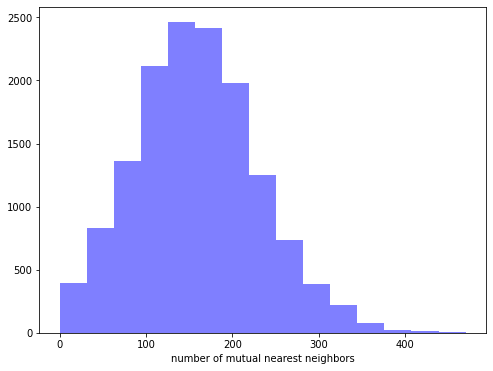

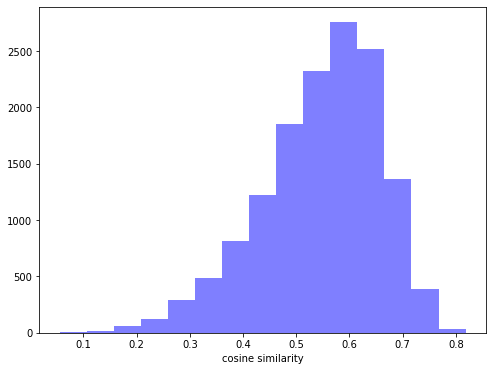

In [33]:
# Visualize the scores
# histogram for number of common neighbors 
# get scores only
nn_scores = [x for x,y in nn]
num_bins = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('number of mutual nearest neighbors')
n, bins, patches = ax.hist(nn_scores, num_bins, facecolor='blue', alpha=0.5)
# plt.title(r' Number of Mutual Nearest Neigbors Histogram for Freuency')
plt.savefig(pic_name+'_nn_hist')

# histogram for cosine scores
cos_scores = [x for x,y in cosdist ]
num_bins = 15
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('cosine similarity')
n, bins, patches = ax.hist(cos_scores, num_bins, facecolor='blue', alpha=0.5)
plt.savefig(pic_name +'_cos_hist')

In [51]:
def freq_scatter_plot(plot_type):
    if plot_type == 'cos':
        words = [y for x,y in cosdist]
        scores = cos_scores
        freq_1 = np.log([count_vocab_val1[y] for x,y in cosdist])
        freq_2 = np.log([count_vocab_val2[y] for x,y in cosdist])
        freq_tot = np.log([ count_vocab_val1[y] + count_vocab_val2[y] for x,y in cosdist])
        title1 = r' Cosine Similarity Score and Frequency for COFEA'
        title2 = r' Cosine Similarity Score and Frequency for COCA'
        title3 = r' Cosine Similarity Score and Frequency for Both Periods'
        yaxis = 'cosine similarity'
        save_name = '_cos_freq'
    if plot_type == 'nn':
        words = [y for x,y in nn]
        scores = nn_scores
        freq_1 = np.log([count_vocab_val1[y] for x,y in nn])
        freq_2 = np.log([count_vocab_val2[y] for x,y in nn])
        freq_tot = np.log([ count_vocab_val1[y] + count_vocab_val2[y] for x,y in nn])
        title1 = r' Nearest Neighbor Score and Frequency for COFEA'
        title2 = r' Nearest Neighbor Score and Frequency for COCA'
        title3 = r' Nearest Neighbor Score and Frequency for Both Periods'
        yaxis = 'number of mutual nearest neighbors'
        save_name = '_nn_freq'
    
    # Cofea and Frequency
    model = sm.OLS(scores, sm.add_constant(freq_1))
    results = model.fit()
    fig, ax = plt.subplots(figsize=(8,6))
    plt.title(title1)
    ax.plot(freq_1, scores, 'o', label="data")
    ax.plot(freq_1,results.fittedvalues, 'r--.', label="OLS")
    ax.legend(loc='best')
    print(results.summary())
    
    # COCA and Frequency
    model = sm.OLS(scores,sm.add_constant(freq_2))
    results = model.fit()
    fig, ax = plt.subplots(figsize=(8,6))
    plt.title(title2)
    ax.plot(freq_2, scores, 'o', label="data")
    ax.plot(freq_2,results.fittedvalues, 'r--.', label="OLS")
    ax.legend(loc='best')
    
    # combined frequency
    model = sm.OLS(scores,sm.add_constant(freq_tot))
    results = model.fit()
    fig, ax = plt.subplots(figsize=(16,12))
    plt.title(title3)
    ax.plot(freq_tot,results.fittedvalues, 'k--.', label="OLS")
    ax.legend(loc='best')
    top = np.percentile(scores,95) # 
    bottom = np.percentile(scores,5)
    bottom_five = np.percentile(scores,5)
    target_x = []
    target_y = []
    ddo_x = []
    ddo_y = []
    x = []
    y = []
    for i, word in enumerate(words):
        if word in target_words:
            target_x.append(freq_tot[i])
            target_y.append(scores[i])
        if word in ddo_terms:
            ddo_x.append(freq_tot[i])
            ddo_y.append(scores[i])
        else:
            x.append(freq_tot[i])
            y.append(scores[i])

    #ax.scatter(x, y,color ='blue')        
    ax.scatter(target_x, target_y,color ='red')
    ax.scatter(ddo_x, ddo_y,color ='green')
    top_target = []
    ax.set_ylabel(yaxis)
    ax.set_xlabel('frequency (log scale)')
    for i, word in enumerate(words):
        if  (word in target_words and (scores[i] >= top or scores[i] <= bottom)) or word in ddo_terms:
            ax.annotate(word, (freq_tot[i], scores[i]),fontsize=12)
        if word in target_words and scores[i] <= bottom_five:
            top_target.append(word)
    plt.savefig(pic_name+save_name)
    return top_target
    


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     864.7
Date:                Mon, 23 May 2022   Prob (F-statistic):          1.40e-184
Time:                        12:23:34   Log-Likelihood:                -80598.
No. Observations:               14265   AIC:                         1.612e+05
Df Residuals:                   14263   BIC:                         1.612e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.6660      3.290     19.350      0.0

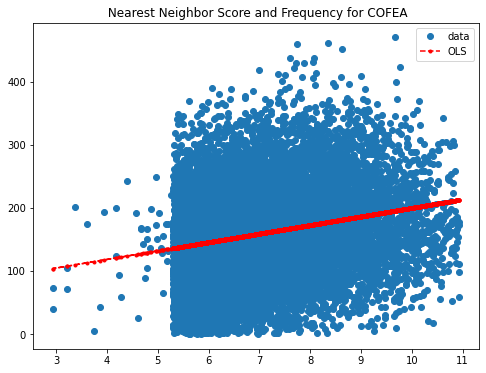

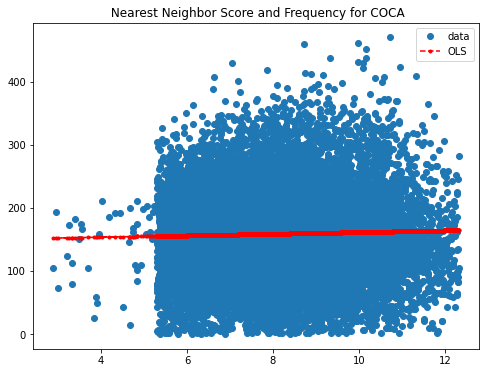

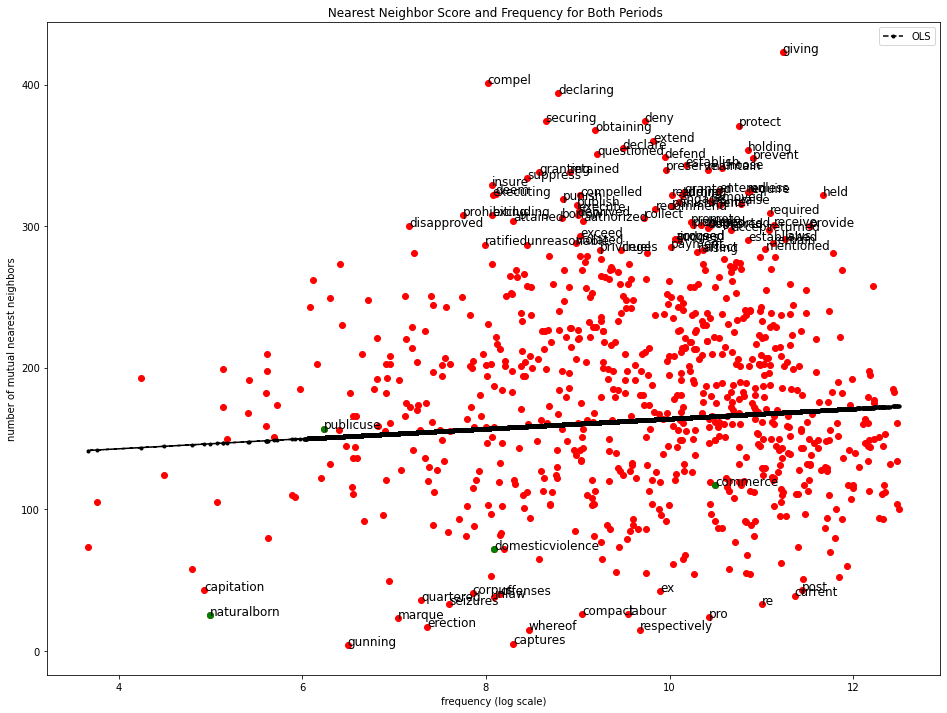

In [52]:
top_nn_target = freq_scatter_plot('nn')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1195.
Date:                Mon, 23 May 2022   Prob (F-statistic):          1.53e-251
Time:                        12:23:45   Log-Likelihood:                 11587.
No. Observations:               14265   AIC:                        -2.317e+04
Df Residuals:                   14263   BIC:                        -2.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3711      0.005     72.257      0.0

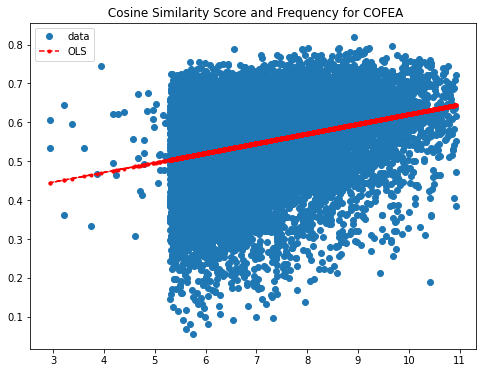

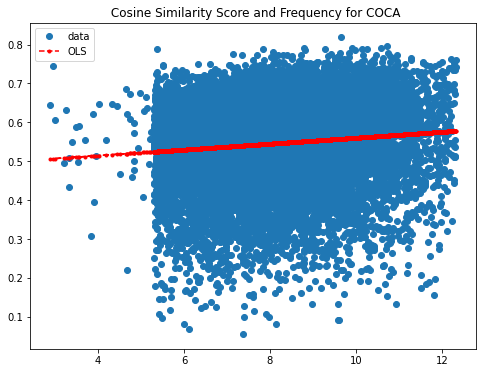

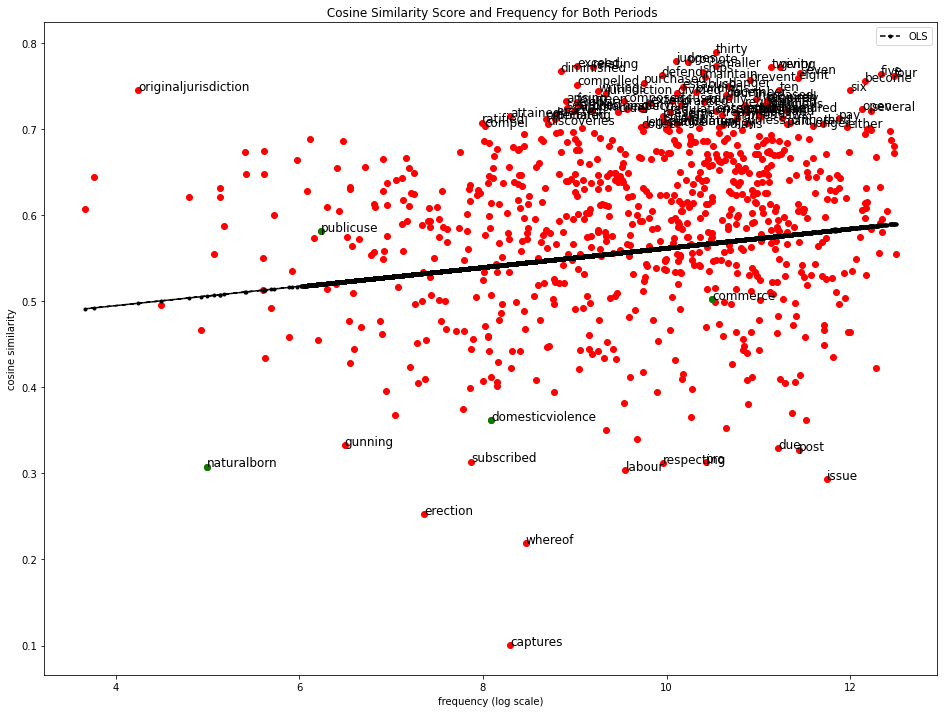

In [53]:
top_cos_target = freq_scatter_plot('cos')

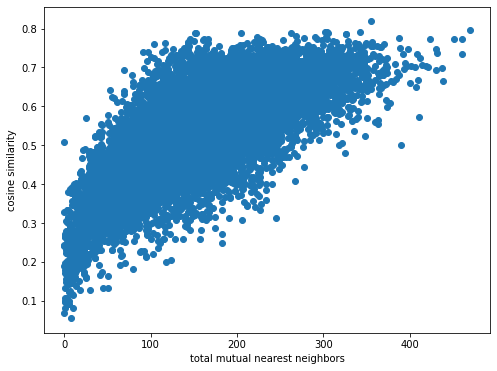

In [37]:
# Compare cosine score to nearest neighbor
scores = {}
for score,word in nn:
    scores[word] = [score]
for score,word in cosdist:
    scores[word].append(score)
x = []
y = []
words = []
for word in scores:
    words.append(word) #may want a tick
    x.append(scores[word][0]) #nn
    y.append(scores[word][1]) #cos

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y)

ax.set_ylabel('cosine similarity')
ax.set_xlabel('total mutual nearest neighbors')

#for i, word in enumerate(words):
#    plt.annotate(word, (x[i], y[i]))

# add terms of interest scores as seperately colored dots
plt.savefig(pic_name+'_nn_cos_comparison')

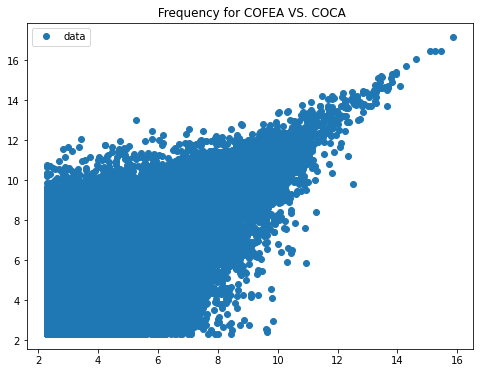

In [38]:
# early frequency to late frequency
early = []
late = []

for word in count_vocab_val1:
    if word in count_vocab_val2:
        early.append(count_vocab_val1[word])
        late.append(count_vocab_val2[word])

early = np.log(early)
late = np.log(late)
model = sm.OLS(late,sm.add_constant(early))
#results = model.fit()
fig, ax = plt.subplots(figsize=(8,6))
plt.title(r' Frequency for COFEA VS. COCA')
ax.plot(early, late, 'o', label="data")
#ax.plot(early,results.fittedvalues, 'r--.', label="OLS")
ax.legend(loc='best')

In [39]:
# part of speech and score
pos = []
for  word in scores:
    doc = nlp(word)
    pos.append(doc[0].pos_)
    
pos = set(pos)
color_key = {}
for i,p in enumerate(pos):
    color_key[p] = i
    
for word in scores:
    doc = nlp(word)
    scores[word].append(color_key[doc[0].pos_])

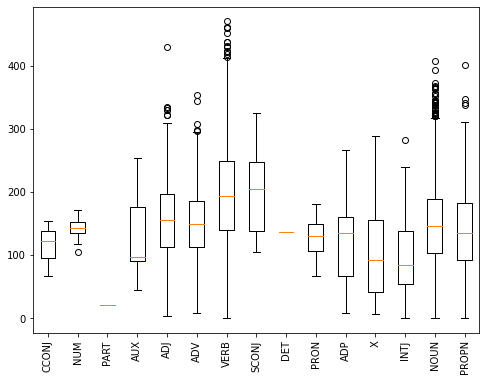

In [40]:
# box plots broken out by parts of speech
pos_data = [[] for _ in range(len(pos))]
for word in scores:
    pos_data[scores[word][2]].append(scores[word][0])
    
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(pos_data)
plt.xticks([i +1 for i in range(len(pos))], pos, rotation='vertical')
plt.savefig(pic_name+'_nn_pos_distribution')

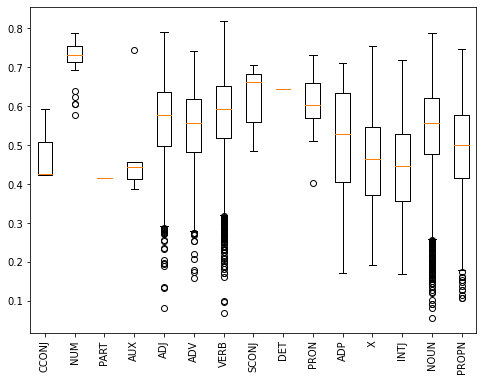

In [41]:
pos_data = [[] for _ in range(len(pos))]
for word in scores:
    pos_data[scores[word][2]].append(scores[word][1])

fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(pos_data)
plt.xticks([i+1 for i in range(len(pos))], pos, rotation='vertical')
plt.savefig(pic_name+'_cos_pos_distribution')

In [42]:
# get the percentile of scores
target_scores = {}
nn_target = []
cos_target = []
total = 0
for word in target_words:
    if word in scores:
        target_scores[word] = scores[word]
        nn_target.append((percentileofscore(nn_scores,scores[word][0]),word))
        cos_target.append((percentileofscore(cos_scores,scores[word][1]),word))

In [43]:
nn_target.sort(key = lambda tup: tup[0])
cos_target.sort(key = lambda tup: tup[0])

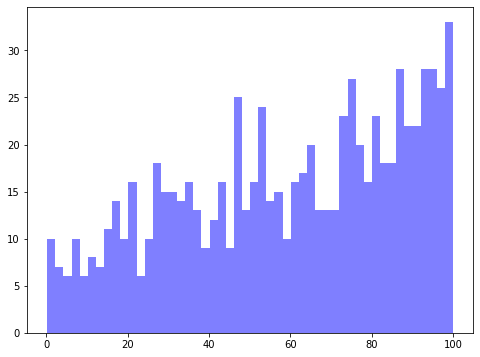

In [44]:
nn_target_percentiles = [x for x,y in nn_target]
num_bins = 50
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(nn_target_percentiles, num_bins, facecolor='blue', alpha=0.5)
plt.show()

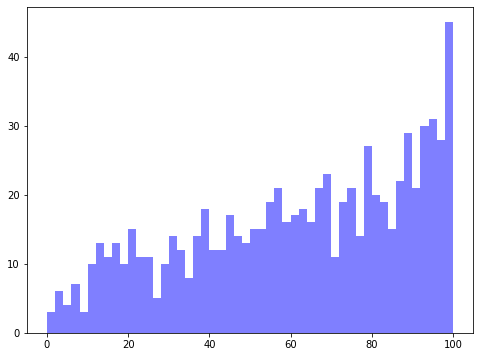

In [45]:
cos_target_percentiles = [x for x,y in cos_target]
num_bins = 50
fig, ax = plt.subplots(figsize=(8,6))
n, bins, patches = ax.hist(cos_target_percentiles, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [54]:
set.intersection(set(top_nn_target),set(top_cos_target))

{'captures',
 'erection',
 'gunning',
 'labour',
 'naturalborn',
 'post',
 'pro',
 'whereof'}

In [55]:
for w_nn in  set(top_cos_target):
    top_diff1, top_diff2 = diff_nn(w_nn, count_vocab_val1, count_vocab_val2, MIN_COUNT,K)
    print(w_nn,end = '\t')
    print(val1 + ' ' + str(count_vocab_val1[w_nn]) + '\t' + val2 + ' ' + str(count_vocab_val2[w_nn]))
    for word in top_diff1:
        print(word,end='\t')
        print(count_vocab_val1[word],end='\t')
    print('\n')
    for word in top_diff2:
        print(word,end='\t')
        print(count_vocab_val2[word],end='\t')
    print('\n')

captures	COFEA 1095	COCA 2927
condemnations	207	seizures	246	spoliations	537	prizes	2954	impressments	284	privateers	2218	seizure	1063	cruizers	580	cruisers	823	confiscations	205	

conveys	1301	evokes	1722	reflects	11809	embodies	1475	encapsulates	238	exemplifies	885	depicts	2795	combines	3686	illustrates	4961	expresses	2643	

pro	COFEA 698	COCA 33045
ad	1459	hoc	204	cum	439	quam	297	quae	219	quod	335	ut	397	inter	229	sed	343	qua	285	

lifers	356	staunchly	455	lifer	222	conservative	33671	liberal	25021	hardline	248	opposing	6309	activist	7819	activists	10518	campaigners	253	

whereof	COFEA 4647	COCA 107
thereof	15517	hereunto	702	whereunto	224	hereto	565	hereof	1097	whereby	4674	wherein	8122	whereupon	1096	which	838275	aforesaid	9162	

despises	257	supposes	318	truthfully	857	omniscient	372	forgives	251	sinned	339	speaks	14723	utters	294	professes	343	candidly	699	

issue	COFEA 7982	COCA 117999
termination	1286	issued	6135	issuing	1485	result	10909	conclusion	5123	success	20072	final	6

In [56]:
top_cos_target

['captures',
 'whereof',
 'erection',
 'issue',
 'labour',
 'naturalborn',
 'respecting',
 'pro',
 'subscribed',
 'post',
 'due',
 'gunning']

In [57]:
top_nn_target

['gunning',
 'captures',
 'respectively',
 'whereof',
 'erection',
 'marque',
 'pro',
 'naturalborn',
 'compact',
 'labour',
 're',
 'seizures',
 'quartered',
 'inlaw',
 'current',
 'offenses',
 'corpus',
 'ex',
 'capitation',
 'post']

In [58]:
# unigram
interest_words = ['natural','born','citizen','commerce','bank','capital','bear','arms','violence']
for word in interest_words:
    print(word)
    print('nn score: '+ str(scores[word][0]),end='\t')
    print('nn percentile: '+ str(percentileofscore(nn_scores,scores[word][0])),end='\t')
    print('cos score: '+ str(scores[word][1]),end='\t')
    print('cos percentile: '+ str(percentileofscore(cos_scores,scores[word][1]))+'\n')

natural
nn score: 132	nn percentile: 36.52646337188924	cos score: 0.6067818382602449	cos percentile: 66.76480897301087

born
nn score: 202	nn percentile: 74.17805818436733	cos score: 0.6730604980065887	cos percentile: 89.54083420960393

citizen
nn score: 208	nn percentile: 76.92253767963547	cos score: 0.6229634418063048	cos percentile: 73.05292674377849

commerce
nn score: 117	nn percentile: 28.68559411146162	cos score: 0.5023672192571099	cos percentile: 31.223273746933053

bank
nn score: 131	nn percentile: 36.04977216964598	cos score: 0.5225204038796326	cos percentile: 36.775324220119174

capital
nn score: 112	nn percentile: 26.214511041009462	cos score: 0.5123858428592726	cos percentile: 33.992288818787245

bear
nn score: 178	nn percentile: 62.337889940413596	cos score: 0.54174521995125	cos percentile: 42.846126883981775

arms
nn score: 111	nn percentile: 25.695758850332982	cos score: 0.47241838453899293	cos percentile: 23.59621451104101

violence
nn score: 171	nn percentile: 58.4297

In [59]:
# bigram
interest_words = ['publicuse','naturalborn','domesticviolence','commerce']
for word in interest_words:
    print(word)
    print('nn score: '+ str(scores[word][0]),end='\t')
    print('nn percentile: '+ str(percentileofscore(nn_scores,scores[word][0])),end='\t')
    print('cos score: '+ str(scores[word][1]),end='\t')
    print('cos percentile: '+ str(percentileofscore(cos_scores,scores[word][1]))+'\n')

publicuse
nn score: 157	nn percentile: 50.51174202593761	cos score: 0.5811956414365118	cos percentile: 56.99964949176306

naturalborn
nn score: 25	nn percentile: 2.0539782684893093	cos score: 0.3079881269462839	cos percentile: 3.4279705573080967

domesticviolence
nn score: 72	nn percentile: 10.942867157378199	cos score: 0.36206597172094457	cos percentile: 7.038205397826849

commerce
nn score: 117	nn percentile: 28.68559411146162	cos score: 0.5023672192571099	cos percentile: 31.223273746933053



In [60]:
for score,word in nn:
    if word in interest_words:
        print_stats(score,word)

naturalborn	mutual nn: 25
COFEA frequency: 101	COCA frequency: 46


immunities	640	naturalized	313	subjects	22719	priviledges	731	dominions	4381	privileges	6925	citizenship	551	loyal	1173	allegiance	2129	aliens	726	

troublemaker	408	womanizer	256	narcissist	242	scumbag	211	pushover	216	hater	266	doer	208	molester	392	buffoon	208	conniving	266	

domesticviolence	mutual nn: 72
COFEA frequency: 25	COCA frequency: 3241


declarewar	313	encroachment	332	invasions	421	aggressions	498	depredation	243	invasion	2482	lawofnations	1199	piracies	203	convoys	345	usurpation	948	

rape	12166	maltreatment	585	harassment	7674	bullying	5104	spousal	714	incest	1232	abusers	1161	victimization	2205	homelessness	1982	homicide	5428	

commerce	mutual nn: 117
COFEA frequency: 21718	COCA frequency: 14552


commercial	7725	intercourse	6995	population	2840	fishery	1583	manufactories	575	importations	622	neutral	3855	neutrals	529	depredations	1667	finances	1878	

interstate	6222	tourism	6995	treasury	8734	chamber